In [1]:
import os
import datetime
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.client import device_lib 

In [2]:
#Some settings
strategy = tf.distribute.MirroredStrategy()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(device_lib.list_local_devices())
tf.keras.backend.set_floatx('float64')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3269440932313652370
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12201329347612944943
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951408640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1527461956020098487
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2047935970097758025
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
for chunk in pd.read_csv("smartmeter.csv", chunksize= 10**6):
    print(chunk)

       device_id     device_name       property       value  \
0            0x7  hardcoded-test     voltage-p3  243.614600   
1            0x7  hardcoded-test     current-p3   -0.076694   
2            0x7  hardcoded-test  current-total   -0.233661   
3            0x7  hardcoded-test       power-p1   -0.271782   
4            0x7  hardcoded-test  current-total   -0.229458   
...          ...             ...            ...         ...   
999995       0x7  hardcoded-test     current-p2   -0.074192   
999996       0x7  hardcoded-test     current-p3   -0.071615   
999997       0x7  hardcoded-test  current-total   -0.225104   
999998       0x7  hardcoded-test       power-p2   -3.300210   
999999       0x7  hardcoded-test       power-p3    0.077652   

                            timestamp  
0       2020-06-26 10:58:05.812186+00  
1       2020-06-26 10:58:05.812186+00  
2       2020-06-26 10:58:05.812186+00  
3       2020-06-26 10:58:05.812186+00  
4       2020-06-26 10:58:11.855156+00  
...

        device_id     device_name       property       value  \
7000000       0x7  hardcoded-test     current-p2   -0.076069   
7000001       0x7  hardcoded-test  current-total   -0.223802   
7000002       0x7  hardcoded-test       power-p2   -0.562977   
7000003       0x7  hardcoded-test       power-p3   -1.339497   
7000004       0x7  hardcoded-test     voltage-p2  246.099400   
...           ...             ...            ...         ...   
7999995       0x7  hardcoded-test     voltage-p1  238.087500   
7999996       0x7  hardcoded-test     voltage-p2  245.880100   
7999997       0x7  hardcoded-test     voltage-p3  244.976200   
7999998       0x7  hardcoded-test       power-p1    1.223019   
7999999       0x7  hardcoded-test       power-p2    0.485325   

                             timestamp  
7000000  2020-05-24 20:56:44.938798+00  
7000001  2020-05-24 20:56:44.938798+00  
7000002  2020-05-24 20:56:44.938798+00  
7000003  2020-05-24 20:56:44.938798+00  
7000004  2020-05-24 20:56:

In [4]:
data = pd.DataFrame(chunk)
data = data.drop(['device_id', 'device_name', 'property'], axis = 1)

In [5]:
# Creating daytime input

def time_d(x):
    k = datetime.datetime.strptime(x, "%H:%M:%S")
    y = k - datetime.datetime(1900, 1, 1)
    return y.total_seconds()

daytime = data['timestamp'].str.slice(start = 11 ,stop=19)
secondsperday = daytime.map(lambda i: time_d(i))

In [6]:
data['timestamp'] = data['timestamp'].str.slice(stop=19)
data['timestamp'] = data['timestamp'].map(lambda i: dt.datetime.strptime(i, '%Y-%m-%d %H:%M:%S'))
parse_dates = [data['timestamp']]

In [7]:
# Creating Weekday input

wd_input = np.array(data['timestamp'].map(lambda i: int(i.weekday())))

In [8]:
# Creating inputs sin\cos

seconds_in_day = 24*60*60
data_seconds = np.array(data['timestamp'].map(lambda i: i.weekday()))

input_sin = np.array(np.sin(2*np.pi*secondsperday/seconds_in_day))
input_cos = np.array(np.cos(2*np.pi*secondsperday/seconds_in_day))

In [9]:
# Putting inputs together in array

df = pd.DataFrame(data = {'value':data['value'], 'input_sin':input_sin, 'input_cos':input_cos, 'input_wd': wd_input})

In [10]:
column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(df)
train_df = pd.DataFrame(df[0:int(n*0.7)])
val_df = pd.DataFrame(df[int(n*0.7):int(n*0.9)])
test_df = pd.DataFrame(df[int(n*0.9):])

num_features = df.shape[1]

In [11]:
# Standardization
train_mean = train_df['value'].mean()
train_std = train_df['value'].std()

train_df['value'] = (train_df['value'] - train_mean) / train_std
val_df['value'] = (val_df['value'] - train_mean) / train_std
test_df['value'] = (test_df['value'] - train_mean) / train_std

In [12]:
# 1st degree differencing
train_df['value'] = train_df['value'] - train_df['value'].shift()

# Handle negative values in 'value' for loging
train_df['value'] = train_df['value'].map(lambda i: abs(i))
train_df.loc[train_df.value <= 0, 'value'] = 0.000000001
train_df['value'] = train_df['value'].map(lambda i: np.log(i))
train_df = train_df.replace(np.nan, 0.000000001)

In [13]:
# 1st degree differencing
val_df['value'] = val_df['value'] - val_df['value'].shift()

# Handle negative values in 'value' for loging
val_df['value'] = val_df['value'].map(lambda i: abs(i))
val_df.loc[val_df.value <= 0, 'value'] = 0.000000001
val_df['value'] = val_df['value'].map(lambda i: np.log(i))
val_df = val_df.replace(np.nan, 0.000000001)

In [14]:
# 1st degree differencing
test_df['value'] = test_df['value'] - test_df['value'].shift()

# Handle negative values in 'value' for loging
test_df['value'] = test_df['value'].map(lambda i: abs(i))
test_df.loc[test_df.value <= 0, 'value'] = 0.000000001
test_df['value'] = test_df['value'].map(lambda i: np.log(i))
test_df = test_df.replace(np.nan, 0.000000001)

In [15]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [16]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def plot(self, model=None, plot_col='value', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [18]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float64)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset


In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [20]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['value'])

In [23]:
baseline = Baseline(label_index=column_indices['value'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2743/2743 [==============================] - 4s 2ms/step - loss: 25.7312 - mean_absolute_error: 3.8646


In [24]:
wide_window = WindowGenerator(
    input_width=25, label_width=25, shift=1,
    label_columns=['value'])

wide_window


Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Label column name(s): ['value']

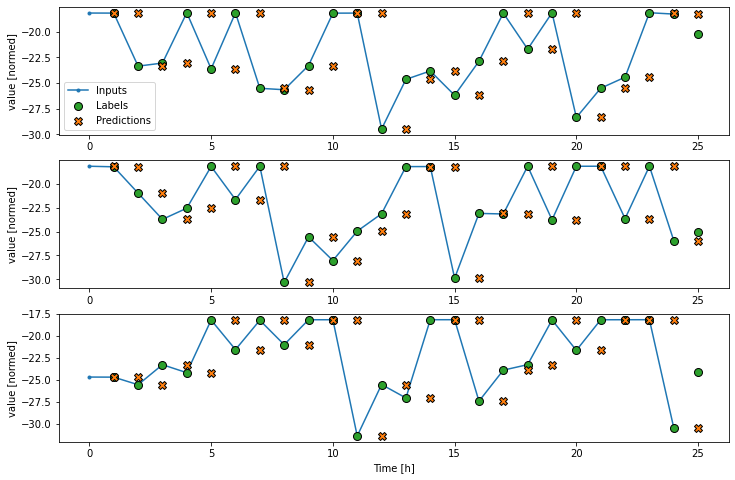

In [25]:
wide_window.plot(baseline)


In [26]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.SGD(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [28]:
### LSTM ###

In [29]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [30]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1,
    label_columns=['value'])

In [31]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

2741/2741 [==============================] - 11s 4ms/step - loss: 12.5831 - mean_absolute_error: 2.9593


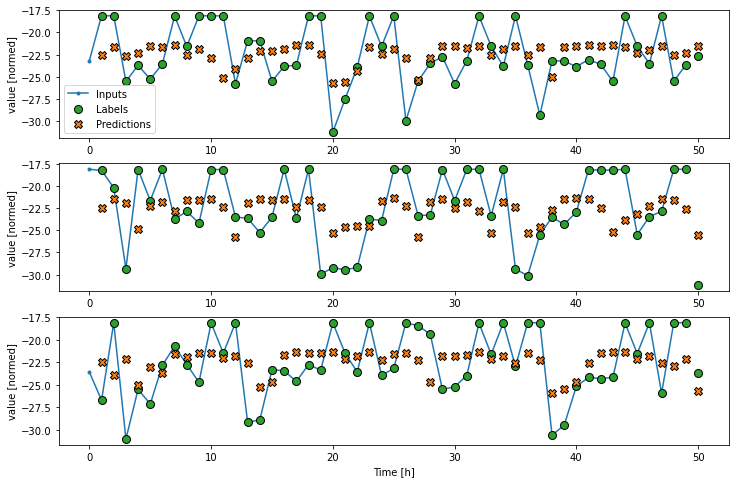

In [32]:
wide_window.plot(lstm_model)